# Chapter 10 - Predicting continuous Target Variables with Regression Analysis

### Exploring a dataset (Housing dataset)

In [68]:
import pandas as pd
df = pd.read_csv('./housing.data.txt', header = None, sep = '\s+')

In [69]:
#Setting column names
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [70]:
#Checking head of dataframe
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


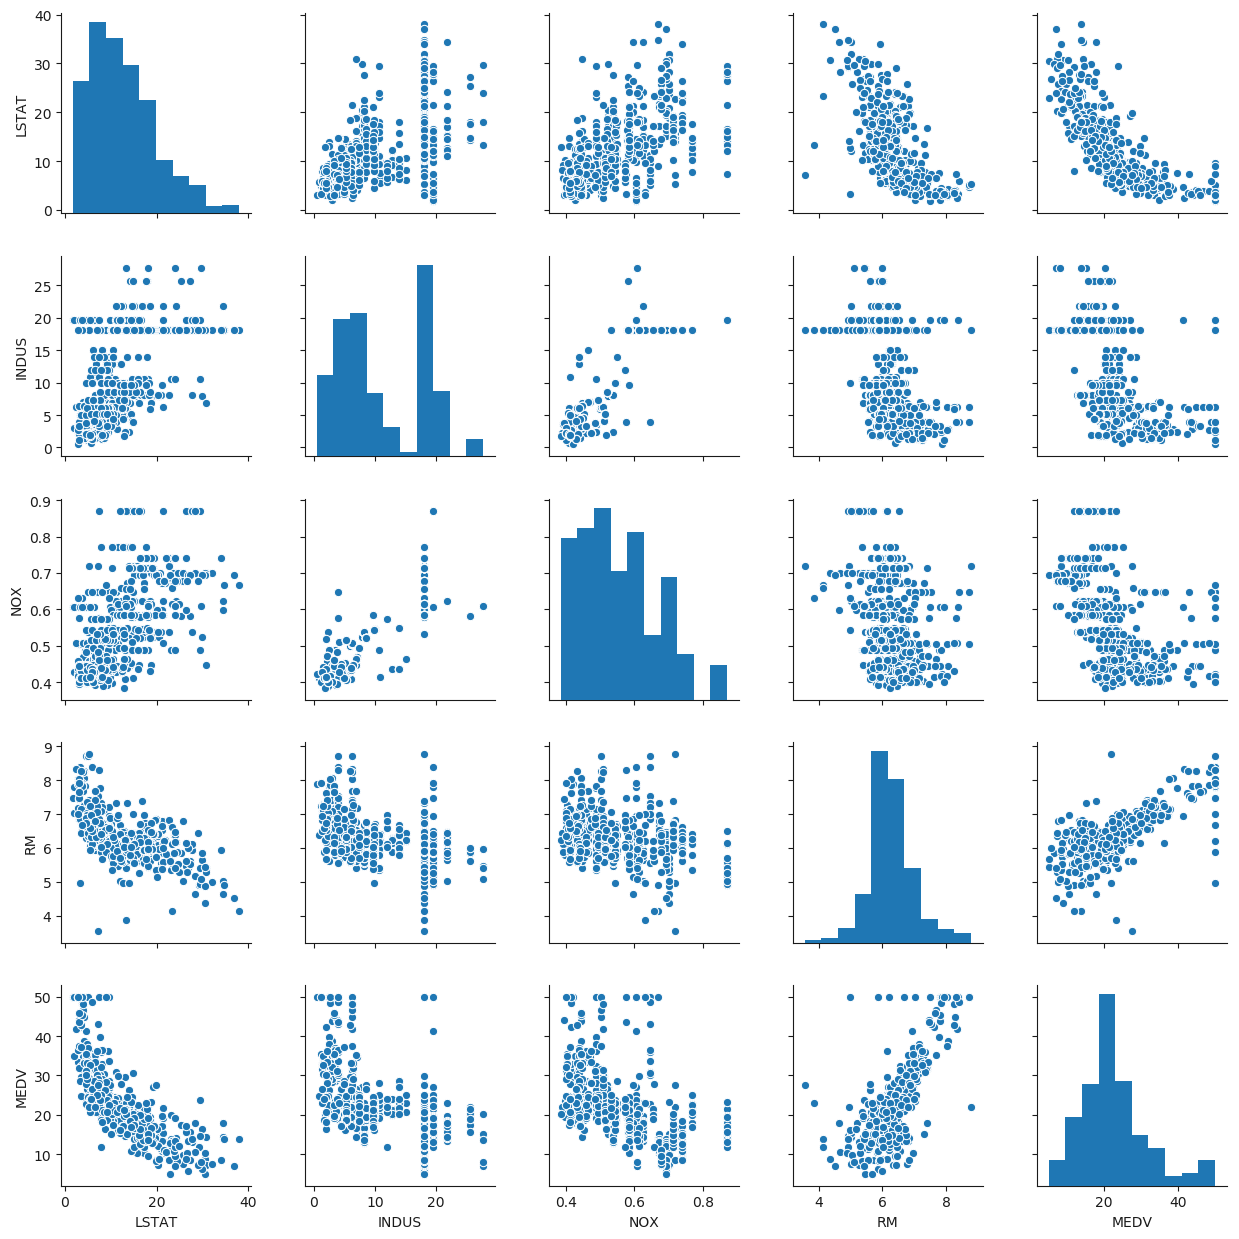

In [71]:
#First step in exploratory data analysis --> creating a scatterplot matrix
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height = 2.5)
plt.tight_layout()
plt.show()
#The plot shows that a linear relationship exists between Rooms and MedianValue 
# and MEDV is normally distributed with a few outliers.

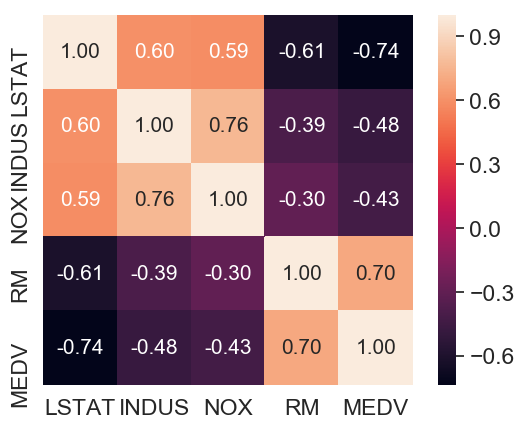

In [72]:
#Creating a correlation matrix (identical to a covariance matrix computed from standardized features)
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale = 1.5)

hm = sns.heatmap(cm,
                cbar = True,
                annot = True,
                square = True,
                fmt = '.2f',
                annot_kws = {'size': 15},
                yticklabels = cols,
                xticklabels = cols)
plt.show()

Highest correlation is between MEDV and LSTAT, however the prior plot demonstrated that a non-linear relationship exists between those two features. For now we will do a simple linear regression between RM and MEDV

### Least square linear regression model

We define a cost function (sum of all predictions - true values) and minimize this via for example Gradient Descent of Stochastic Gradient Desecent. It is identical to the Adaline implementation for logistic regression, however without the unit step function

In [73]:
class LinearRegressionGD(object):
    
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [97]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)



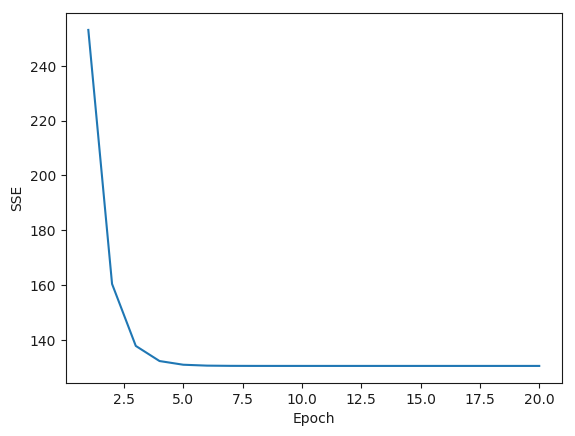

In [75]:
sns.reset_orig() #resets matplotlib style
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [76]:
#Fit linear regression line
def lin_regplot(X, y, model):
    plt.scatter(X, y, c= 'steelblue', edgecolor = 'white', s = 70)
    plt.plot(X, model.predict(X), color = 'black', lw = 2)
    return None

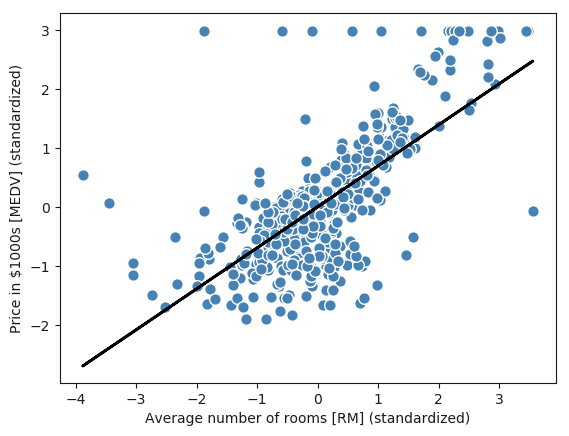

In [77]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

Several observation: Relatively good fit, however for several houses the performance is not good. In addition, several points are lined up at the y = 3 line, suggesting the price of these houses may be clipped.

In [95]:
#Predicting the price of a house with 5 rooms using the inverse_transform of the standaradscaler.
num_rooms_std = sc_x.transform(5.0) #standardized value of 5 rooms
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


In [94]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


With standardized data the intercept (and thus w0) will always be 0. Technically, it is not necessary to update w0 in standardized Linear regression.

In [92]:
print('price: %.3f' % X)

price: 10.840


## Estimating coefficitne of a regression model via scikit-learn

Scikit-learn has a few estimators that use the LIBLINEAR library and are more efficient and advanced (and work better with unstandardized data).

In [98]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


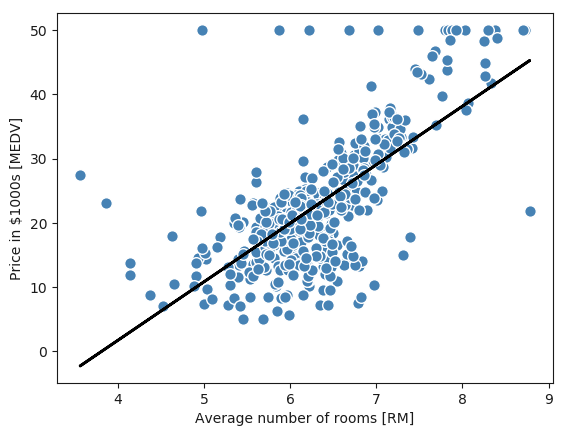

In [100]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()
#Altough the slope and intercept differ from this implementation, the plot looks identical

## Fitting a robus regression using RANSAC

Logistic regression is easily biased by the presence of outliers. We can detect (and/or delete) them, however an alternative is the RANdom SAmple Consensus (RANSAC) method. It fits a model to a subset of the data, the so-called inliers.

Steps;
* Select a random number of samples to be inliers and fit the model
* Test all other data points against the fitted model and add those points that fall with a user-given tolerance to the inliers
* Refit the model using all inliers
* Estimate the error of the fitted model versus the inliers
* Terminate th algorithm if performance meets a ceratin user-defined threshold or a fixed number of interation were reached.

In [102]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials = 100,
                        min_samples = 50,
                        loss = 'absolute_loss',
                        residual_threshold = 5.0,
                        random_state= 0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_metric=None, residual_threshold=5.0, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

By default sklearn uses the MAD (Median Absolute Deviation) estimate to select the inlier threshold, however the threshold choice is problem-specific.

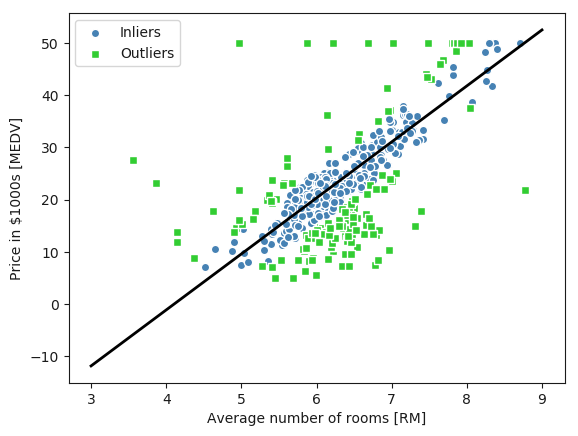

In [103]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
           c = 'steelblue', edgecolor = 'white',
           marker = 'o', label = 'Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c = 'limegreen', edgecolor = 'white',
           marker = 's', label = 'Outliers')

plt.plot(line_X, line_y_ransac, color = 'black', lw = 2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc = 'upper left')
plt.show()

In [104]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


Slope and interecept differ slightly from other implementation. We however do not know (yet) what it does on the performance of the model

## Evaluating the performance of linear regression models

In [105]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

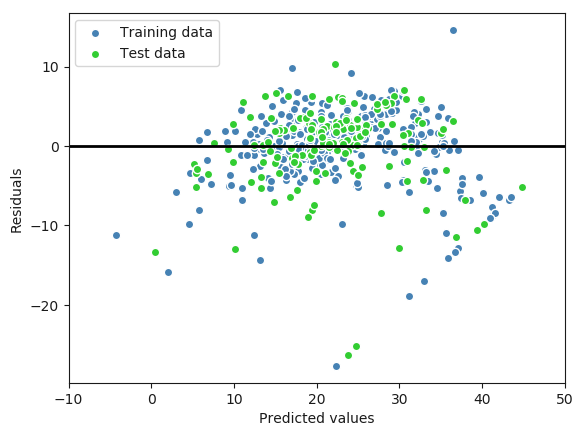

In [108]:
#We cannot plot the regression line as we use multiple features, 
# but we can plot the residuals to check if the errors are randomly distributed.
plt.scatter(y_train_pred, y_train_pred - y_train,
           c = 'steelblue', edgecolor = 'white', label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c = 'limegreen', edgecolor = 'white', label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc ='upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, color ='black', lw = 2)
plt.xlim([-10,50])
plt.show()

With a perfect prediction, all residuals would be 0. All residuals should be randomly distributed. IF any patterns can be recognized, our model fails to extract some of the information from the feature. We can detect outliers by the points with a large deviation from the center line.

#### Mean square error
The mean square error is a quantitative measure of a model's performance. It is the average value of the SSE (Sum of Squared errors) and thus the average (square) error of the observations.

In [109]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


MSE of test set is larger --> Probably overfitting the training data

#### R2 (R-squared)

R2 is also called the coefficient of determination, which can be understood as a standardized version of the MSE. R2 is the fraction of response variance that is captured by the model. 

1 - (SSE / SST) where SSE is the sum of squared errors and SST is the total sum of squares (variance of the response); or 1-(MSE/Var(y)).

In [110]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


## Regularized methods for regression

Regularization is used to tackle the problem of overfiting by adding addiitonal information and thereby  shrinking the parameter values of the model to induce a penalty agains complexity. The most popular approaches to regularized linear regression are the so-called Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO) and ELastic Net.

<b>Ridge</b> <br />
Simply add the squared sum of the weights to our least-squares cost function

<b>LASSO</b> <br />
Depending on the regularization strength, some weights can become zero (can also be useful as supervised features selector).

<b>Elastic net</b> <br />
Has both an L1 penalty to generate sparsity and L2 penalty to overcome some of the limitations of LASSO (as for example the limited number of selected variables)

In [111]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 1.0) #alphay = regularization strength

from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1.0)

from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha = 1.0, l1_ratio = 0.5) #if l1-ratio == 1; model is identical to lasso


## Polynomial regression

Turns a linear regression model into a curve; useful if the assumption of linearity is violated.

In [113]:
#Add a second degree polynomial term
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree =2)
X_quad = quadratic.fit_transform(X)

In [116]:
#Fit a simple linear regression model for comparison
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [117]:
#fit a multiple regression model on the transofrmed features for polynomial regression
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

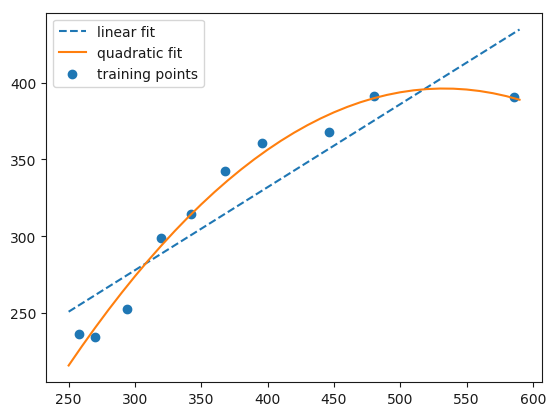

In [118]:
#plot the results
plt.scatter(X, y, label = 'training points')
plt.plot(X_fit, y_lin_fit, label = 'linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'quadratic fit')
plt.legend(loc = 'upper left')
plt.show()

In [119]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % 
          (mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' %
          (r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))


Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the housing dataset

model the relationship between house prices and LSTAT as using second degree (quadratic) and third degree (cubic) polynomials compared to a linear fit.

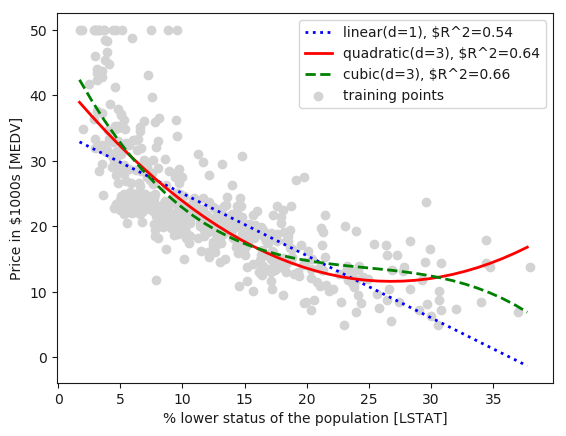

In [126]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

#create quadratic features
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

#plot results
plt.scatter(X, y, label = 'training points', color = 'lightgray')

plt.plot(X_fit, y_lin_fit,
         label = 'linear(d=1), $R^2=%.2f' % linear_r2,
         color = 'blue',
         lw = 2,
         linestyle = ":")

plt.plot(X_fit, y_quad_fit,
         label = 'quadratic(d=3), $R^2=%.2f' % quadratic_r2,
         color = 'red',
         lw = 2,
         linestyle = "-")

plt.plot(X_fit, y_cubic_fit,
         label = 'cubic(d=3), $R^2=%.2f' % cubic_r2,
         color = 'green',
         lw = 2,
         linestyle = "--")

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc = 'upper right')
plt.show()

The cubic fit captures the relationship between the two features best. However, adding polynomial features increases model complexity with possible overfitting. Adding polynomial features is not always the best option, as some non-linear relationships can be overcome by a log-transformation of one of the features

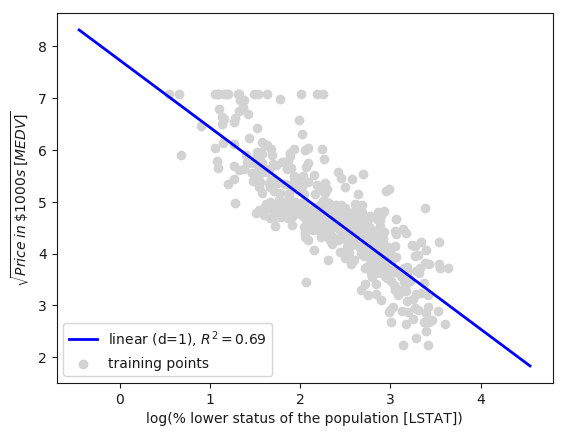

In [129]:
#transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

#fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

#plot results
plt.scatter(X_log, y_sqrt,
           label = 'training points',
           color = 'lightgray')
plt.plot(X_fit, y_lin_fit,
        label = 'linear (d=1), $R^2=%.2f$' %linear_r2, color = 'blue', lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc = 'lower left')
plt.show()

## Nonlinear relationships using random forests

Decision trees do not require any transofrmation of features if dealing with nonlinear data. MSE is used as impurity metric in decision tree regressors; MSE is also referred to as within-node variance (which is why splitting criterion is also better known as variance reductiON).

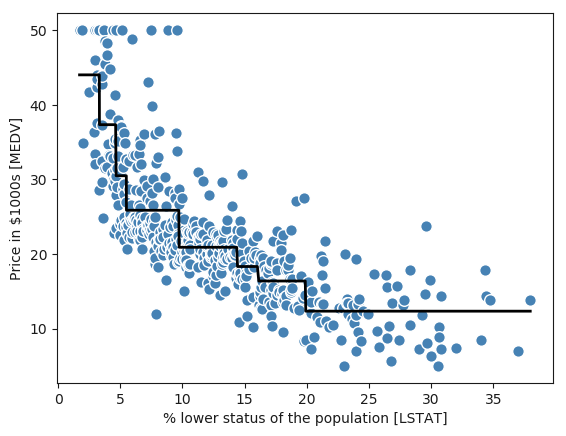

In [133]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [135]:
#Randomforest
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 1000,
                             criterion = 'mse',
                             random_state = 1,
                             n_jobs = -1)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


As we can see the randomforest regressor is also overfitting, but also able to explain almost 88% of the variance in the test data.

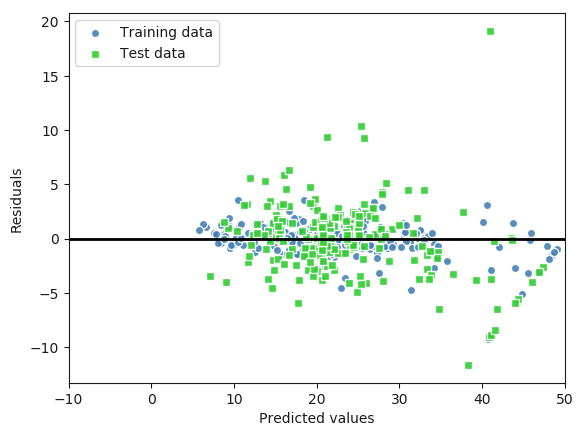

In [136]:
#plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train,
           c = 'steelblue', edgecolor = 'white', marker = 'o',
           s = 35, alpha = 0.9, label = 'Training data')

plt.scatter(y_test_pred, y_test_pred - y_test,
           c = 'limegreen', edgecolor = 'white', marker = 's',
           s = 35, alpha= 0.9, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'black')
plt.xlim([-10,50])
plt.show()